In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import copy



from mr_complex_resonator import MR_complex_resonator as MR_complex_resonator
from mr_lekid import MR_LEKID as MR_LEKID
import utils




colormap = plt.cm.gnuplot
colormap2 = plt.cm.viridis
colormap3 = plt.cm.turbo
colormap4 = plt.cm.summer_r


def to_dbm(x):
    return 10*np.log10(1e3*x)

def to_W(x):
    return 10**(x/10.) * 1e-3


plt.rcParams.update({'xtick.labelsize' : '18'})
plt.rcParams.update({'ytick.labelsize' : '18'})
plt.rcParams.update({'legend.fontsize' : '13'})
plt.rcParams.update({'font.size' : '18'})
plt.rcParams.update({'axes.formatter.useoffset' : 'False'})
plt.rcParams['axes.grid'] = True

## generating a resonator and plotting its transfer function


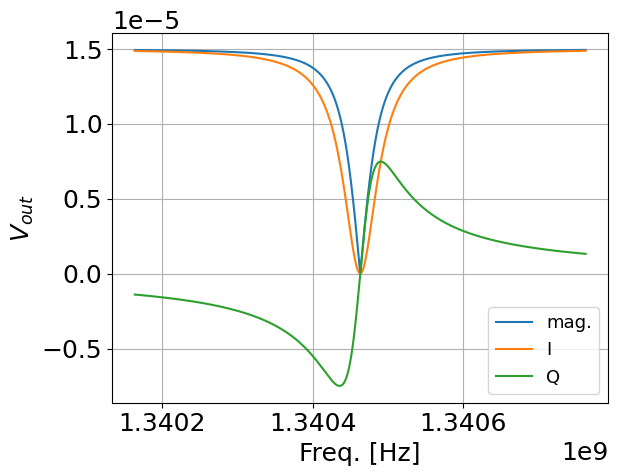

In [4]:
res = MR_complex_resonator() 

fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), label='mag.')
plt.plot(frange, Vout.real, label='I')
plt.plot(frange, Vout.imag, label='Q')

plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')
plt.legend()

### under different optical loads

note that the default behaviour is to determine Lg based on $alpha_k$, so if you are going to change the loading, you should establish Lg from a low-load model, then fix it at this value

Text(0.5, 0, 'Freq. [Hz]')

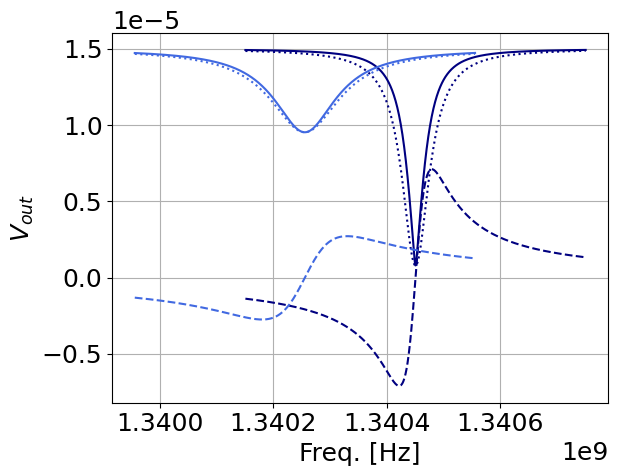

In [5]:
dark_Popt = 1e-15
sky_Popt = 1e-12

darkcolour = 'navy'
skycolour = 'royalblue'

baseline_res = MR_complex_resonator(Popt=dark_Popt, alpha_k=0.5)
Lg = baseline_res.Lg 


# resonator under dark conditions
res = MR_complex_resonator(Popt=dark_Popt, fix_Lg=Lg)
fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), color=darkcolour, label='mag.')
plt.plot(frange, Vout.real, ':', color=darkcolour, label='I')
plt.plot(frange, Vout.imag, '--', color=darkcolour, label='Q')



# resonator under sky conditions
res = MR_complex_resonator(Popt=sky_Popt, fix_Lg=Lg)
fr = res.lekid.compute_fr()

span = 300e3
frange = np.linspace(fr-span, fr+span, 1000)
Vout = res.lekid.compute_Vout(frange)
plt.plot(frange, abs(Vout), color=skycolour, label='mag.')
plt.plot(frange, Vout.real, ':', color=skycolour, label='I')
plt.plot(frange, Vout.imag, '--', color=skycolour, label='Q')


plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')

### temperature



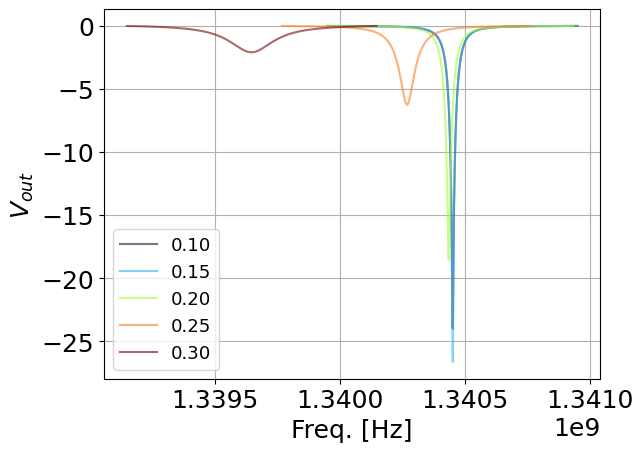

In [7]:
Trange = np.linspace(0.1, 0.3, 5)
Popt = 1e-15


baseline_res = MR_complex_resonator(Popt=1e-15, alpha_k=0.5)
Lg = baseline_res.Lg 

for T in Trange:
    plotcolour = colormap3((T-min(Trange)) / (max(Trange) - min(Trange)))
    # resonator under dark conditions
    res = MR_complex_resonator(Popt=Popt, T=T, fix_Lg=Lg)
    fr = res.lekid.compute_fr()
    
    span = 0.5e6
    frange = np.linspace(fr-span, fr+span, 1000)
    Vout = res.lekid.compute_Vout(frange)
    mag_db = 20*np.log10(abs(Vout)/abs(Vout[-1]))
    plt.plot(frange, mag_db, color=plotcolour, alpha=0.6, label='%.2f'%T)



plt.ylabel('$V_{out}$')
plt.xlabel('Freq. [Hz]')
plt.legend()

## responsivity


Some quantities of interest here:
- change in output voltage per change in optical load (eg, due to photon noise)
    - useful to investigate this as a function of some detector parameter
- change in qp density per change in optical load


#### qp responsivity

make a resonator (mostly for bookkeeping of other params)

get the nqp

add some optical load (eg, at the scale of a photon noise fluctuation)

get the new nqp



In [14]:
Popt=1e-13 # operational loading levels


res = MR_complex_resonator(Popt=1e-16) # still use dark loading here to get the Lg
Lg = res.Lg


res_params = dict(fix_Lg=Lg, Popt=Popt)
res =  MR_complex_resonator(**res_params)

# get a photon noise-scale fluctuation in optical load
dPopt = res.est_photon_noise()
print('Popt: %.1e W, dPopt: %.1e W'%(Popt, dPopt))

# evaluate the change in qp density for this change in Popt
## first, get the baseline nqp, for the operational Popt
nqp = res.calc_nqp()

# now, make a new resonator with Popt + dPopt
res_params['Popt'] = Popt + dPopt
res_loaded = MR_complex_resonator(**res_params)
nqp_loaded = res_loaded.calc_nqp()

print('nqp before: %f, nqp after: %f'%(nqp, nqp_loaded))

qp_responsivity = (nqp_loaded - nqp) / ((Popt+dPopt) - Popt)
print('qp responsivity (dnqp / dPopt): %.2e'%qp_responsivity)

Popt: 1.0e-13 W, dPopt: 5.0e-18 W
nqp before: 847.004460, nqp after: 847.025657
qp responsivity (dnqp / dPopt): 4.23e+15


#### device responsivity: dVout / dPopt

Let's do this one as a function of carrier frequency within the resonance

we'll separate the voltage changes into the I and Q components to see the reactive/dissipative responses of the resonator

and we'll normalize the outputs by the input voltage, since otherwise the result is just a linear function of Vin which is not super useful

Popt: 1.0e-13 W, dPopt: 5.0e-18 W


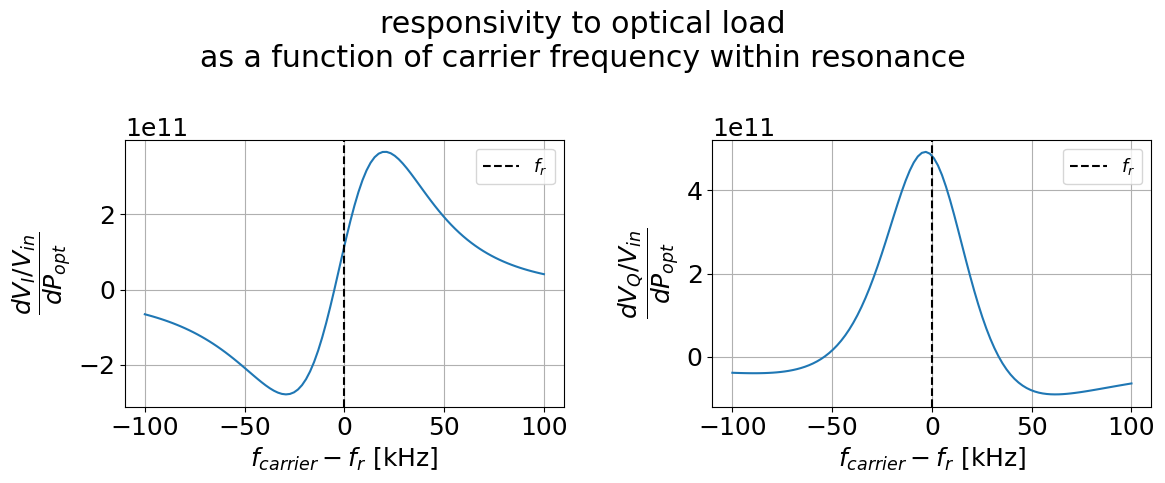

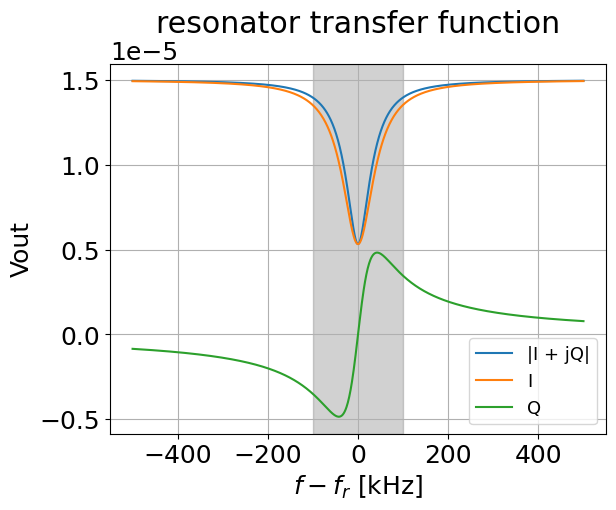

In [26]:
fig = plt.figure(figsize=(2*6, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)


Popt=1e-13 # operational loading levels


res = MR_complex_resonator(Popt=1e-16) # still use dark loading here to get the Lg
Lg = res.Lg


res_params = dict(fix_Lg=Lg, Popt=Popt)
res =  MR_complex_resonator(**res_params)

# get a photon noise-scale fluctuation in optical load
dPopt = res.est_photon_noise()
print('Popt: %.1e W, dPopt: %.1e W'%(Popt, dPopt))


# a new resonator with Popt + dPopt
res_params_loaded = copy.deepcopy(res_params)
res_params_loaded['Popt'] = Popt + dPopt
res_loaded = MR_complex_resonator(**res_params_loaded)


# evaluate the change in carrier output voltage for this change in Popt:

# first, get the range of carrier frequencies to evaluate the responsivity at
fr = res.lekid.compute_fr()
span = 100e3
carrier_frange = np.linspace(fr-span, fr+span, 100)


# let's also plot the resonance shape just for context
fig2 = plt.figure()
cx = fig2.add_subplot()
sweep_span = 500e3
fsweeprange = np.linspace(fr-sweep_span, fr+sweep_span, 1000)
sweep_Vout = res.lekid.compute_Vout(fsweeprange)
cx.plot(1e-3*(fsweeprange - fr), abs(sweep_Vout), label='|I + jQ|')
cx.plot(1e-3*(fsweeprange - fr), sweep_Vout.real, label='I')
cx.plot(1e-3*(fsweeprange - fr), sweep_Vout.imag, label='Q')
cx.axvspan(1e-3*(-span), 1e-3*(span), color='dimgrey', alpha=0.3)
cx.legend()
cx.set_ylabel('Vout')
cx.set_xlabel('$f - f_r$ [kHz]')
cx.set_title('resonator transfer function')

dVi, dVq = [], []
for carrier_freq in carrier_frange:

    ## get the baseline Vout, for the operational Popt
    Vout = res.lekid.compute_Vout(carrier_freq)
    
    # the carrier stays in the same place, so just evaluate the new voltage at that frequency
    Vout_loaded = res_loaded.lekid.compute_Vout(carrier_freq)

    delta_Vout = Vout_loaded - Vout
    dVi.append(delta_Vout.real)
    dVq.append(delta_Vout.imag)

dVi = np.asarray(dVi)
dVq = np.asarray(dVq)

resp_i = (dVi/res.Vin) / dPopt
resp_q = (dVq/res.Vin) / dPopt

plotfreq = 1e-3*(carrier_frange - fr)
ax.plot(plotfreq, resp_i)
bx.plot(plotfreq, resp_q)

for x in [ax,bx]:
    x.axvline(0, linestyle='--', color='k', label='$f_r$')
    x.legend()
    x.set_xlabel('$f_{carrier} - f_r$ [kHz]')


ax.set_ylabel('$\dfrac{dV_I/V_{in}}{dP_{opt}}$')
bx.set_ylabel('$\dfrac{dV_Q/V_{in}}{dP_{opt}}$')

fig.suptitle('responsivity to optical load\nas a function of carrier frequency within resonance')
fig.tight_layout()
    


##### as above but only at one carrier frequency, and vary some other parameter


Eg the optical load

At each optical load, the resonance frequency will shift. Let's assume that we retuned each time, so we'll reinitialize a carrier at the correct fr for each Popt. But then as before, when we add the dPopt, we leave the carrier in the same place and evaluate the change in voltage that it saw

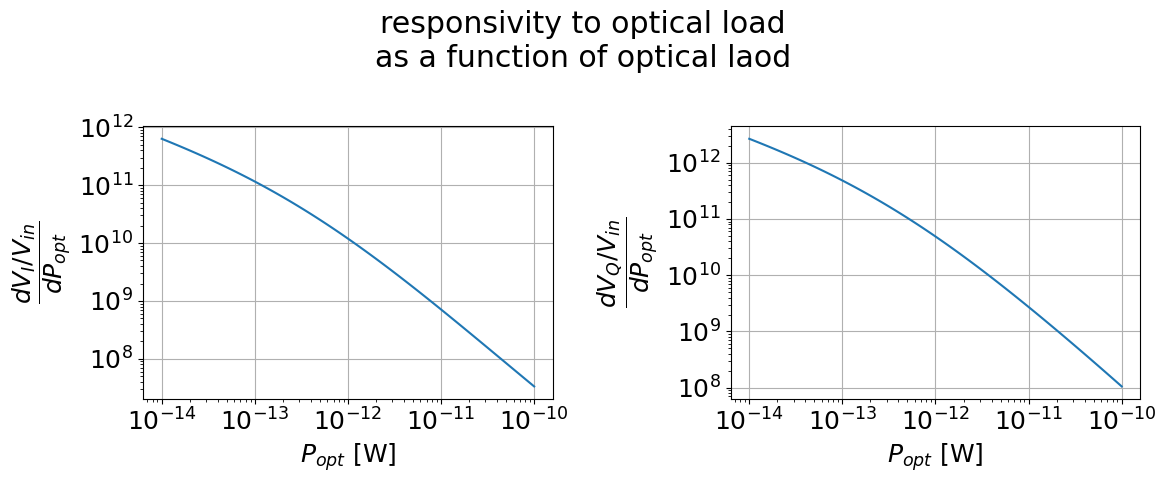

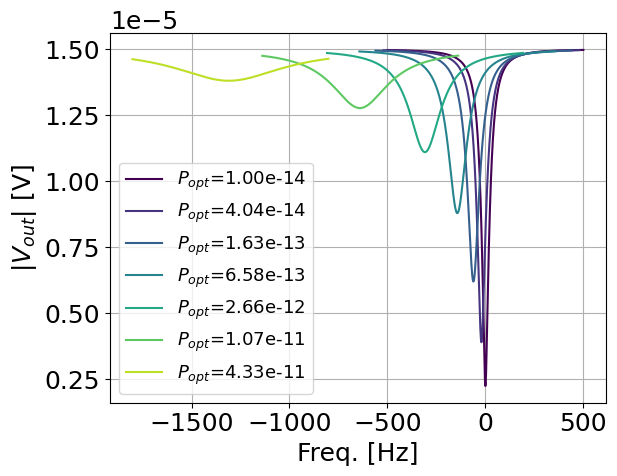

In [37]:
fig = plt.figure(figsize=(2*6, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

# let's also plot the resonance shape just for context
fig2 = plt.figure()
cx = fig2.add_subplot()
sweep_span = 500e3


# operational loading levels
Prange = np.logspace(-14, -10, 100)


res = MR_complex_resonator(Popt=1e-16) # still use dark loading here to get the Lg
Lg = res.Lg


dVi, dVq = [], []
dPopts = []
for p, Popt in enumerate(Prange):
    res_params = dict(fix_Lg=Lg, Popt=Popt)
    res =  MR_complex_resonator(**res_params)
    fr = res.lekid.compute_fr()
    carrier_freq = fr
    if p == 0:
        f0 = fr

    Vout = res.lekid.compute_Vout(carrier_freq)
    
    # get a photon noise-scale fluctuation in optical load, AT THIS OPTICAL LOAD
    dPopt = res.est_photon_noise()
    dPopts.append(dPopt)
    # print('Popt: %.1e W, dPopt: %.1e W'%(Popt, dPopt))


    # a new resonator with Popt + dPopt
    res_params_loaded = copy.deepcopy(res_params)
    res_params_loaded['Popt'] = Popt + dPopt
    res_loaded = MR_complex_resonator(**res_params_loaded)
    Vout_loaded = res_loaded.lekid.compute_Vout(carrier_freq)

    delta_Vout = Vout_loaded - Vout
    dVi.append(delta_Vout.real)
    dVq.append(delta_Vout.imag)

    # plot the resonator shape every several Popt values, to see how it changes
    if not p%15:
        plotcolour = colormap2(float(p) / len(Prange))
        sweepspan = 500e3
        sweep_freq = np.linspace(fr-sweepspan, fr+sweepspan, 1000)
        sweep_iq = res.lekid.compute_Vout(sweep_freq)
        cx.plot(1e-3*(sweep_freq-f0), abs(sweep_iq), color=plotcolour, label='$P_{opt}$=%.2e'%Popt)

dVi = np.asarray(dVi)
dVq = np.asarray(dVq)
dPopts = np.asarray(dPopts)
resp_I = (dVi/res.Vin) / dPopts
resp_Q = (dVq/res.Vin) / dPopts

ax.plot(Prange, resp_I)
bx.plot(Prange, resp_Q)

for x in [ax, bx]:
    x.set_xscale('log')
    x.set_yscale('log')
    x.set_xlabel('$P_{opt}$ [W]')

cx.legend()
cx.set_ylabel('$|V_{out}|$ [V]')
cx.set_xlabel('Freq. [Hz]')


ax.set_ylabel('$\dfrac{dV_I/V_{in}}{dP_{opt}}$')
bx.set_ylabel('$\dfrac{dV_Q/V_{in}}{dP_{opt}}$')

fig.suptitle('responsivity to optical load\nas a function of optical laod')
fig.tight_layout()
    


## generate noise

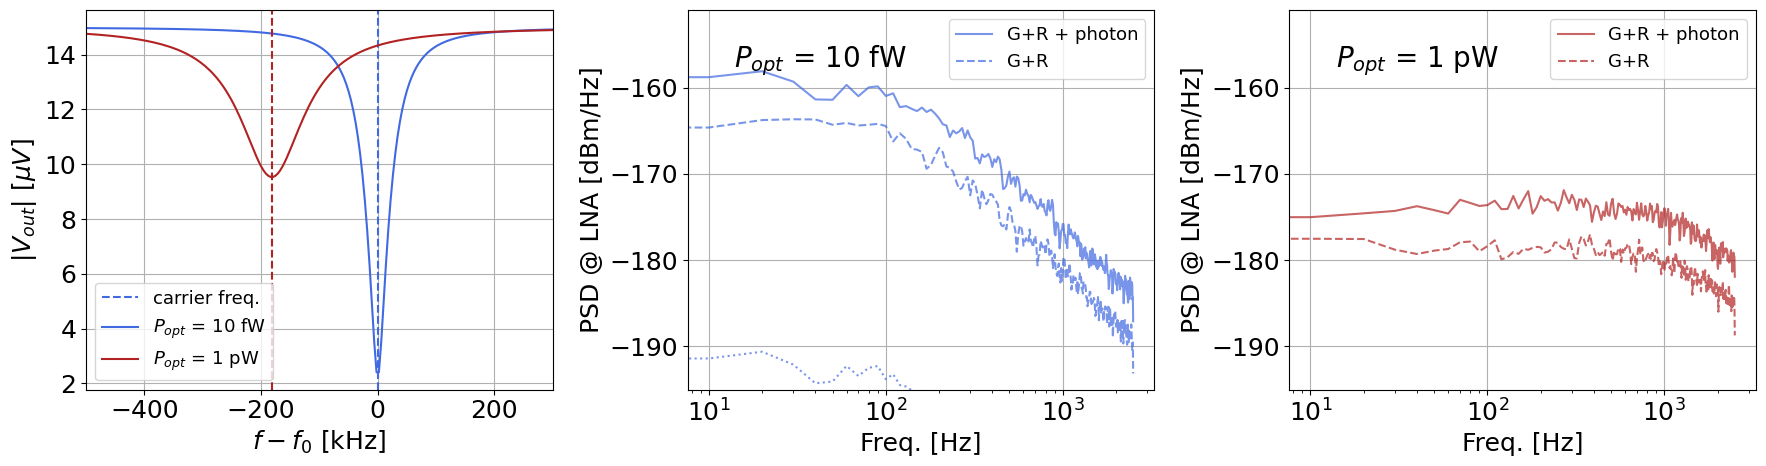

In [38]:


res = MR_complex_resonator()
Lg = res.lekid.Lg

fig = plt.figure(figsize=(6*3, 5))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)
Prange = [1e-14, 1e-12]

noise_frange = np.logspace(-2, 4, 100)

plotcolours = ['royalblue', 'firebrick']

for p, Popt in enumerate(Prange):
    if p == 1:
        noise_plot = cx
    else:
        noise_plot = bx
    res = MR_complex_resonator(fix_Lg=Lg, Popt=Popt)
    fr = res.lekid.compute_fr()

    # put the carrier at the resonant frequency (or somewhere else if you want!)
    carrier_freq = fr
    if p == 0:
        fr0 = fr
        clabel = 'carrier freq.'
    else:
        clabel = ''
    ax.axvline(1e-3*(carrier_freq-fr0), linestyle='--', color=plotcolours[p], label=clabel)
    
    
    span = 2000e3
    frange = np.linspace(fr-span, fr+span, 1000)
    
    plotfreq = 1e-3*(frange - fr0)
    Vout = res.lekid.compute_Vout(frange)
    if p == 0:
        plabel = '$P_{opt}$ = 10 fW'
    else:
        plabel = '$P_{opt}$ = 1 pW'
    ax.plot(plotfreq, 1e6*abs(Vout), color=plotcolours[p], label=plabel)
    

    fs = 5e3
    N = int(5e3)
    rbw = fs/N
    

    # comute spectrum for total resonator noise (GR + generation due to photon shot noise)
    # generate qp number fluctuation spectral density 
    frequencies = np.fft.fftfreq(N, d=1./fs)
    frequencies, Nqp_spectrum_gr = res.calc_gr_PSD_thermal_optical(frange=frequencies, nu_opt=150e9) 
    # turn number fluctuation spectral density into timestream of qp number density values
    nqp_timestream_gr = utils.make_nqp_timestream_from_Nqp_spectrum(res, frequencies=frequencies, Nqp_spectrum=Nqp_spectrum_gr,
                                                                       rbw=rbw, baseline_nqp=res.calc_nqp())
    # put these nqp values through the resonance, and compute the resulting voltage timestream that the carrier "saw"
    Vout_timestream_gr = res.make_carrier_Vout_timestream_for_nqp_timestream(carrier_freq=carrier_freq, nqp_timestream=nqp_timestream_gr, fs=fs, N=N)
    # orientation of the IQ plane is arbitary, so might as well rotate the timestream as we do IRL, to put max response in Q direction
    Vout_timestream_gr, _ = utils.rotate_iq_plane(Vout_timestream_gr)
    
    psdfreq, psdi = signal.welch(Vout_timestream_gr.real/np.sqrt(50.), fs=fs, nperseg=N/10)
    psdfreq, psdq = signal.welch(Vout_timestream_gr.imag/np.sqrt(50.), fs=fs, nperseg=N/10)
    
    
    noise_plot.plot(psdfreq, to_dbm(psdi), ':', alpha=0.7, color=plotcolours[p])
    noise_plot.plot(psdfreq, to_dbm(psdq), alpha=0.7, color=plotcolours[p], label='G+R + photon')

    
    
    # thermalized GR only
    frequencies = np.fft.fftfreq(N, d=1./fs)
    frequencies, Nqp_spectrum_gr = res.calc_gr_PSD(frange=frequencies) 
    nqp_timestream_gr = utils.make_nqp_timestream_from_Nqp_spectrum(res, frequencies=frequencies, Nqp_spectrum=Nqp_spectrum_gr,
                                                                       rbw=rbw, baseline_nqp=res.calc_nqp())
    Vout_timestream_gr = res.make_carrier_Vout_timestream_for_nqp_timestream(carrier_freq=carrier_freq, nqp_timestream=nqp_timestream_gr, fs=fs, N=N)
    Vout_timestream_gr, _ = utils.rotate_iq_plane(Vout_timestream_gr)
    
    psdfreq, psdi = signal.welch(Vout_timestream_gr.real/np.sqrt(50.), fs=fs, nperseg=N/10)
    psdfreq, psdq = signal.welch(Vout_timestream_gr.imag/np.sqrt(50.), fs=fs, nperseg=N/10)
    noise_plot.plot(psdfreq, to_dbm(psdi), '--', alpha=0.7, color=plotcolours[p])
    noise_plot.plot(psdfreq, to_dbm(psdq), '--', alpha=0.7, color=plotcolours[p], label='G+R')
    
    noise_plot.text(0.1, 0.85, '%s'%plabel, fontsize=20, transform=noise_plot.transAxes)
    

    
ax.set_ylabel('$|V_{out}|$ [$\mu V$]')
ax.set_xlabel('$f - f_0$ [kHz]')
ax.legend(loc='lower left')
ax.set_xlim(-500, 300)


for x in [bx, cx]:    
    x.set_xscale('log')
    x.set_ylim(-195, -151)
    x.set_ylabel('PSD @ LNA [dBm/Hz]')
    x.set_xlabel('Freq. [Hz]')
    x.legend(loc='upper right')
    
fig.tight_layout()